In [1]:
!pip install --upgrade pip
!pip install python-binance


# Option valuation model based on historical prices

In [1]:
import importlib.util
import os
google_colab_spec = importlib.util.find_spec("google") and importlib.util.find_spec("google.colab")
if google_colab_spec:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path = '/content/drive/MyDrive/Colab Notebooks/Ethereum Prices'
else:
    path = f'{os.environ["HOME"]}/Library/CloudStorage/GoogleDrive-chris.perso@gmail.com/My Drive/Colab Notebooks/Ethereum Prices'
    
os.environ['CACHE_PATH'] = path
os.environ['DISABLE_CACHE'] = 'FALSE'

from datetime import datetime, timedelta, date
import pandas
import numpy
from numpy import ndarray
from matplotlib import pyplot
import math
import requests
from typing import Tuple

import binanceprices

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"
BINANCE_SYMBOL = 'ETHUSDT'

prices_df = binanceprices.load_prices(path, BINANCE_SYMBOL, COUNT_YEARS)

daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()


loading 2014 ............
loading 2015 ............
loading 2016 ............
loading 2017 ............
loading 2018 ............
loading 2019 ............
loading 2020 ............
loading 2021 ............
loading 2022 ............
loading 2023 ............
loading 2024 
interrupting at 2024/01


## Option valuation model: input parameters here

In [18]:
target_period_days = 9
CUT_OFF_YEAR = 2020

instrument_code = BINANCE_SYMBOL[:3]

headers = {"Content-Type": "application/json"}
base_url = 'https://www.deribit.com/api/v2/public'

get_options = f"{base_url}/get_instruments?currency={instrument_code}&kind=option&expired=false"
response_options = requests.get(get_options, headers=headers)
if response_options.status_code != 200:
    raise IOError(f'request failed with error {response_options.status_code}')

result = response_options.json()['result']
puts = {}
calls = {}
for option in result:
    if option['option_type'] == 'put':
        puts[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']
    elif option['option_type'] == 'call':
        calls[(option['strike'], datetime.fromtimestamp(option['expiration_timestamp'] / 1000).date())] = option['instrument_id']

target_expiry = min({k[1] for k in puts.keys()}, key=lambda d: abs(d - (date.today() + timedelta(days=target_period_days))))

get_current_price = f"{base_url}/get_index_price?index_name={instrument_code.lower()}_usd"
response_current_price = requests.get(get_current_price, headers=headers)

if response_current_price.status_code != 200:
    raise IOError(f'request failed with error {response_current_price.status_code}')

current_price = response_current_price.json()['result']['index_price']
remaining_days = (target_expiry - date.today()).days
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(remaining_days).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days)
period_close_dates = prices_df.groupby(prices_df.index.date)['close'].last().shift(-remaining_days).index
df = pandas.DataFrame({
    'daily_prices': daily_prices,
    'period_close_series': period_close_series,
})
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index)

df = df[df.index.year>=CUT_OFF_YEAR]

def generate_strikes(price: float):
    if price <= 10000:
        step = 100.
    else:
        step = 500.
        
    closest_hundred = round(price / step) * step
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 3):
        strikes.add(closest_hundred + i * step)
        strikes.add(closest_hundred - i * step)

    return strikes

def load_bid_ask(options, strike: float, expiry: date) -> Tuple[float, float]:
    instrument_id = options[(strike, expiry)]
    get_bid_ask = f"{base_url}/get_order_book_by_instrument_id?instrument_id={instrument_id}&depth=1"
    response_bid_ask = requests.get(get_bid_ask, headers=headers)

    if response_bid_ask.status_code != 200:
        raise IOError(f'request failed with error {response_bid_ask.status_code}')

    bid_ask = response_bid_ask.json()['result']
    bid = ask = None
    if 'bids' in bid_ask and bid_ask['bids'] and bid_ask['bids'][0] and bid_ask['bids'][0][0]:
        bid = bid_ask['bids'][0][0]
    if 'asks' in bid_ask and bid_ask['asks'] and bid_ask['asks'][0] and bid_ask['asks'][0][0]:
        ask = bid_ask['asks'][0][0]
    return bid, ask

strike_prices = list(generate_strikes(current_price))

for count, strike_price in enumerate(strike_prices, start=1):
    strike_factor = strike_price / current_price
    df[f'strike_{count}'] = df['daily_prices'].multiply(strike_factor)
    df[f'strike_pct_{count}'] = strike_factor

    df[f'call_value_{count}'] = df['period_close_series'].subtract(df[f'strike_{count}'])
    df.loc[df[f'call_value_{count}'] < 0., f'call_value_{count}'] = 0.
    df[f'call_value_pct_{count}'] = df[f'call_value_{count}'].divide(df['daily_prices'])

    df[f'put_value_{count}'] = df[f'strike_{count}'].subtract(df['period_close_series'])
    df.loc[df[f'put_value_{count}'] < 0., f'put_value_{count}'] = 0.
    df[f'put_value_pct_{count}'] = df[f'put_value_{count}'].divide(df['daily_prices'])


option_chain = list()
for count, strike_price in enumerate(strike_prices, start=1):
    put_bid, put_ask = load_bid_ask(puts, strike_price, target_expiry)
    call_bid, call_ask = load_bid_ask(calls, strike_price, target_expiry)
    strike_data = {
        'strike': strike_price,
        'value_call': df[f'call_value_pct_{count}'].mean() * current_price,
        'value_put': df[f'put_value_pct_{count}'].mean() * current_price,
        'value_call_median': df[f'call_value_pct_{count}'].quantile(0.5) * current_price,
        'value_put_median': df[f'put_value_pct_{count}'].quantile(0.5) * current_price,
        'value_call_pct': df[f'call_value_pct_{count}'].mean(),
        'call_ask': call_ask,
        'value_put_pct': df[f'put_value_pct_{count}'].mean(),
        'put_ask': put_ask
    }
    if strike_price < current_price:
        strike_data['value_call_pct'] = None
    if strike_price > current_price:
        strike_data['value_put_pct'] = None

    option_chain.append(strike_data)

option_chain_df = pandas.DataFrame(option_chain).set_index('strike').sort_index()

#
index_put = 1
index_call = -2
#
cost, value = (option_chain_df.iloc[index_put]['put_ask'] + option_chain_df.iloc[index_call]['call_ask'], 
 option_chain_df.iloc[index_put]['value_put_pct'] + option_chain_df.iloc[index_call]['value_call_pct']
)
print(f'trading put {option_chain_df.iloc[index_put].name:.0f} and call {option_chain_df.iloc[index_call].name:.0f}')
print(f'cost: {cost:.2f} / value: {value:.2f}')

option_chain_df

trading put 2100 and call 2300
cost: 0.02 / value: 0.07


,value_call,value_put,value_call_median,value_put_median,value_call_pct,call_ask,value_put_pct,put_ask
strike,,,,,,,,
2000.0,297.733220,27.346221,246.415083,0.000000,NaN,0.1190,0.012373,0.0039
2100.0,216.232817,45.845818,146.415083,0.000000,NaN,0.0695,0.020744,0.0095
2200.0,147.978089,77.591089,46.415083,0.000000,NaN,0.0300,0.035108,0.0225
2300.0,98.320653,127.933653,0.000000,53.584917,0.044487,0.0115,NaN,0.0505
2400.0,63.602193,193.215193,0.000000,153.584917,0.028778,0.0044,NaN,0.0915


# Some statistics

In [17]:
df['daily_prices'].describe()

count    1453.000000
mean     1710.834343
std      1110.934471
min       107.670000
25%       728.910000
50%      1668.200000
75%      2239.600000
max      4807.980000
Name: daily_prices, dtype: float64

<Axes: title={'center': 'Historical prices ETH'}>

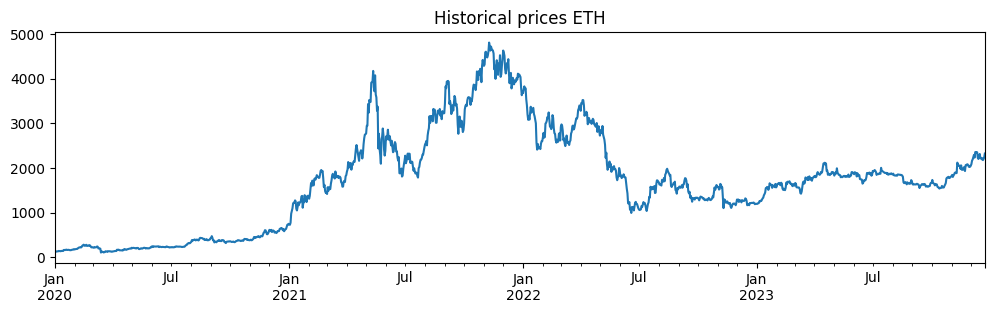

In [4]:
df['daily_prices'].plot(figsize=(12,3), title=f"Historical prices {instrument_code}")

## Performance distribution

Text(0.5, 1.0, 'Period (8 days) Performance Underlying')

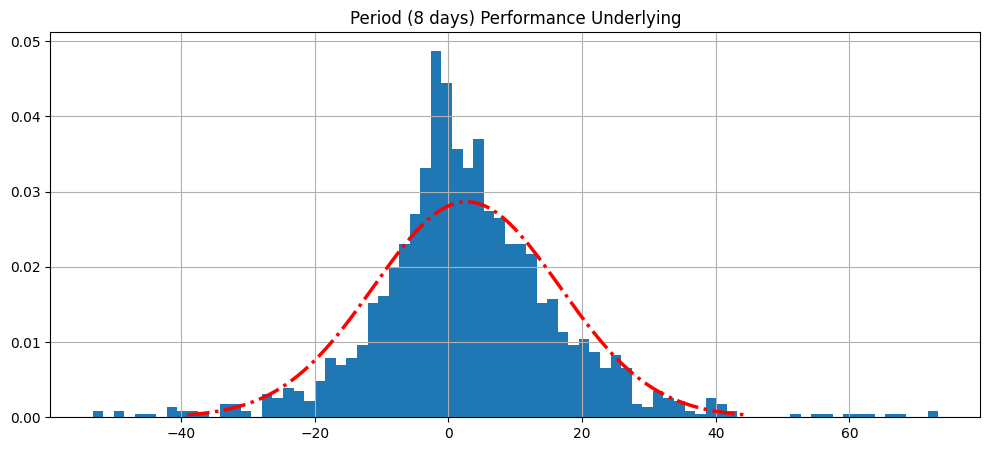

In [5]:
df['period_perf_pct'].hist(bins=80, density=True, figsize=(12, 5))

def normpdf(x: ndarray, mu: float, sigma: float):
    sigma = abs(float(sigma))
    z = (x - float(mu)) / sigma
    return numpy.exp(-0.5 * numpy.square(z)) / (math.sqrt(2. * math.pi) * sigma)

mu = df['period_perf_pct'].describe()['mean']
sigma = df['period_perf_pct'].describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title(f'Period ({remaining_days} days) Performance Underlying')

Text(0.5, 1.0, 'Daily Performance Underlying')

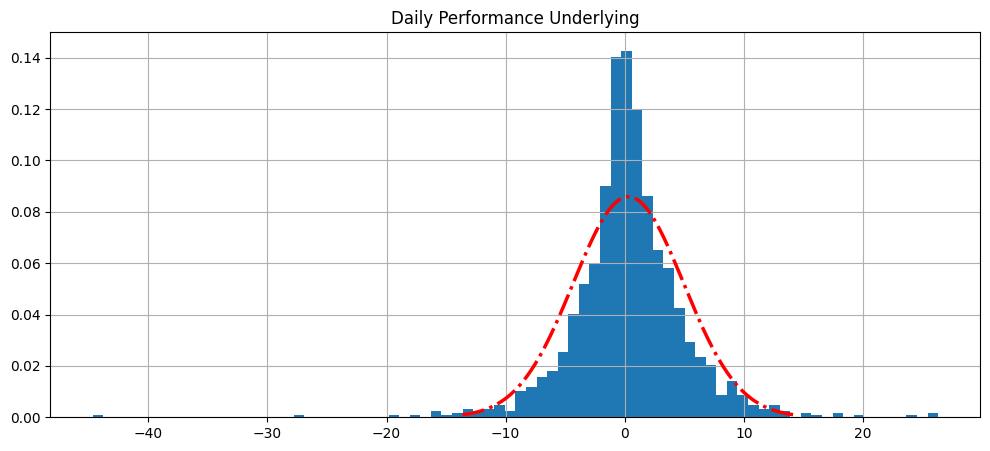

In [6]:
daily_perf = df["daily_prices"].shift(-1).divide(df["daily_prices"]).subtract(1.).dropna().multiply(100.)
daily_perf.hist(bins=80, density=True, figsize=(12, 5))

mu = daily_perf.describe()['mean']
sigma = daily_perf.describe()['std']
# Generate the normal distribution curve
x = numpy.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = normpdf(x, mu, sigma)

# Plot the normal distribution curve
pyplot.plot(x, y, linestyle='dashdot', linewidth=2.5, color='red')
pyplot.title('Daily Performance Underlying')

<Axes: >

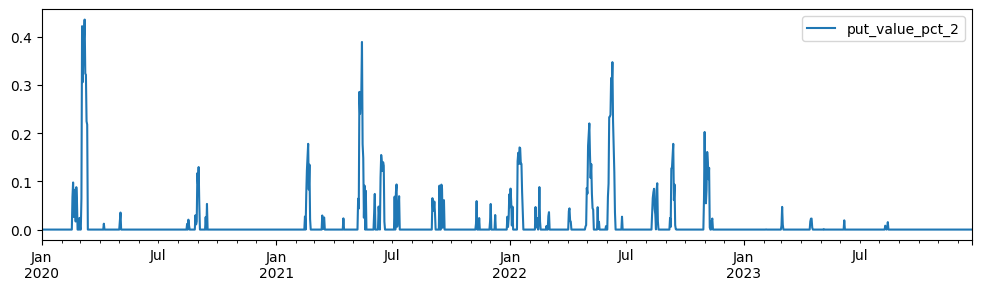

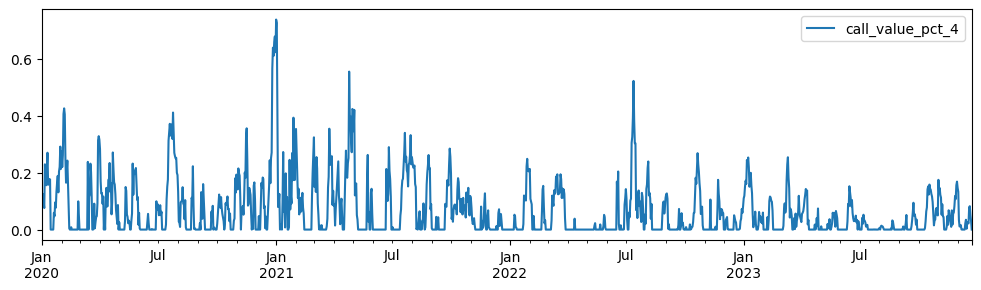

In [7]:
df[['put_value_pct_2']].plot(figsize=(12,3))
df[['call_value_pct_4']].plot(figsize=(12,3))


In [19]:
calls

{(600.0, datetime.date(2024, 1, 26)): 273793,
 (700.0, datetime.date(2024, 1, 26)): 273994,
 (800.0, datetime.date(2024, 1, 26)): 273795,
 (900.0, datetime.date(2024, 1, 26)): 273797,
 (1000.0, datetime.date(2024, 1, 26)): 273799,
 (1100.0, datetime.date(2024, 1, 26)): 273801,
 (1200.0, datetime.date(2024, 1, 26)): 273803,
 (1300.0, datetime.date(2024, 1, 26)): 273805,
 (1400.0, datetime.date(2024, 1, 26)): 273807,
 (1500.0, datetime.date(2024, 1, 26)): 273809,
 (1600.0, datetime.date(2024, 1, 26)): 273811,
 (1700.0, datetime.date(2024, 1, 26)): 273813,
 (1800.0, datetime.date(2024, 1, 26)): 273815,
 (1900.0, datetime.date(2024, 1, 26)): 273817,
 (2000.0, datetime.date(2024, 1, 26)): 273819,
 (2050.0, datetime.date(2024, 1, 26)): 284802,
 (2100.0, datetime.date(2024, 1, 26)): 273821,
 (2150.0, datetime.date(2024, 1, 26)): 284804,
 (2200.0, datetime.date(2024, 1, 26)): 273823,
 (2250.0, datetime.date(2024, 1, 26)): 284806,
 (2300.0, datetime.date(2024, 1, 26)): 273825,
 (2350.0, datetim